In [2]:
# Импорты необходимых библиотек
import pandas as pd  # Для работы с данными (DataFrame, чтение CSV)
import seaborn as sns  # Для визуализации (lineplot в plot_history)
import regex  # Для регулярных выражений (валидация имени, лучшая поддержка Unicode)
from dateutil import parser  # Для парсинга дат в fix_date
from matplotlib import pyplot as plt  # Для графиков в plot_history
from datetime import datetime  # Для работы с датами и временем (now() в _add_operation)
from IPython.display import display  # Для отображения DataFrame в Jupyter (опционально)

# Отключаем предупреждения Pandas для чистоты вывода
pd.options.mode.chained_assignment = None


In [3]:
# ---
# Задание 1: Реализация базового класса Account
# ---

class Account:
    """
    Базовый класс, моделирующий банковский счёт.
    Выполняет базовые операции, ведёт учёт истории, предоставляет аналитику.
    """
    
    # Приватный атрибут класса для генерации уникальных номеров счёта (отсчёт начинается с 1000, этап 1)
    _account_counter = 1000

    def __init__(self, account_holder: str, balance: float = 0, account_number: str= None):
        """
        Конструктор класса (этап 2). 
        Автоматически формирует номер счёта 'ACC-XXXX'.
        Валидирует имя владельца и баланс.
        """
        # Валидация имени владельца (п.4 задания 2)
        self._account_holder = self._validate_holder_name(account_holder)
        # Валидация начального баланса (не может быть отрицательным, п.4 задания 2)
        self._balance = self._validate_balance(balance, 'создание счёта')
        
        # Автоматическая генерация номера счёта (этап 1)
        if account_number:
            
            self._account_number = account_number
        else:
            self._account_number = f'ACC-{Account._account_counter}'
            Account._account_counter += 1
        
        # Инициализация истории операций (список структурированных словарей, этап 1)
        self._operations_history = []
        # Атрибут для типа счёта (для наследования, этап 4 задания 2)
        self.account_type = None
        # Вывод для демонстрации создания счёта
        print(f"Счёт {self._account_number} для {self._account_holder} успешно создан. Баланс: {self._balance} у.е.")

    @staticmethod
    def _validate_holder_name(account_holder: str) -> str:
        """
        Валидация имени владельца (п.4 задания 2).
        Формат: "Имя Фамилия" с заглавных букв, кириллица или латиница.
        Вызывает исключение при несоответствии.
        """
        account_holder = account_holder.title().strip()  # Нормализация: заглавные буквы, удаление лишних пробелов
        pattern = r'^[A-ZА-ЯЁ][a-zа-яё]*\s[A-ZА-ЯЁ][a-zа-яё]*$'  # Паттерн для "Имя Фамилия" (заглавные первые буквы, кириллица/латиница)
        if not isinstance(account_holder, str) or not regex.match(pattern, account_holder):
            raise ValueError("Неверный формат имени владельца. Ожидается 'Имя Фамилия' с заглавных букв (кириллица или латиница).")
        return account_holder

    @staticmethod
    def _validate_balance(value: float, operation_type: str) -> float:
        """
        Валидация начального баланса или суммы (п.4 задания 2).
        Должна быть положительным числом, иначе исключение.
        """
        if not isinstance(value, (int, float)) or value < 0:
            raise ValueError(f'Операция "{operation_type}" не выполнена: баланс/сумма не может быть отрицательной.')
        return float(value)
    
    @staticmethod
    def _validate_amount(amount: float):
        """
        Валидация суммы операции (п.4 задания 2).
        Должна быть положительной, иначе исключение.
        """
        if not isinstance(amount, (int, float)) or amount <= 0:
            raise ValueError("Сумма операции должна быть положительным числом.")

    @staticmethod
    def fix_date(df, date_col='date', raw_col='raw_date'):
        """
        Исправление аномалий в датах (перепутанные день/месяц) на основе разницы с предыдущей датой (часть очистки, задание 3).
        """
        df_fixed = df.copy() 
    
        df_fixed['time_diff_days'] = df_fixed[date_col].diff().dt.days
    
        ANOMALY_THRESHOLD = -10 
        anomalous_indices = df_fixed[df_fixed['time_diff_days'] < ANOMALY_THRESHOLD].index
    
        if anomalous_indices.empty:
            return df_fixed.drop(columns=['time_diff_days'], errors='ignore')

        for index in anomalous_indices:
            raw_date_str = df_fixed.loc[index, raw_col]
        
            try:
                new_date = parser.parse(raw_date_str, fuzzy=True, dayfirst=True)
            
                df_fixed.loc[index, 'temp_date'] = new_date
                temp_diff = df_fixed['temp_date'].fillna(df_fixed[date_col]).diff().dt.days
            
                if temp_diff.loc[index] >= 0:
                    df_fixed.loc[index, date_col] = new_date
                else:
                    df_fixed.loc[index, date_col] = pd.NaT

            except Exception:
                df_fixed.loc[index, date_col] = pd.NaT
            
        df_fixed = df_fixed.drop(columns=['time_diff_days', 'temp_date'], errors='ignore')
        df_fixed = df_fixed.dropna(subset=[date_col]) 
    
        return df_fixed.sort_values(by=date_col) 
    
    def load_history_from_file(self, filepath: str):
        """
        Загрузка истории из файла (CSV или JSON, задание 3).
        Фильтрует по аккаунту, очищает данные, добавляет новые операции, обновляет баланс.
        """
        if self.account_type is None:
            print("account_type не определён. Метод доступен только для подклассов (CheckingAccount/SavingsAccount).")
            return
        
        print(f"\nЗагрузка истории для {self._account_number} из {filepath}...")
        
        try:
            if filepath.endswith('.csv'):
                df = pd.read_csv(filepath)
            elif filepath.endswith('.json'):
                df = pd.read_json(filepath)
            else:        
                raise ValueError('Неверный формат файла (ожидается .csv или .json).')
            
        except Exception as e:
            print(f"Ошибка при чтении файла: {e}")
            return
       
        # Фильтрация данных по номеру аккаунта и типу счета (файл общий для всех, задание 3)
        df_filtered = df[
            (df['account_number'] == self._account_number) &
            (df['account_type'] == self.account_type)
        ]

        if df_filtered.empty:
            print(f"Транзакции для {self._account_number} ({self.account_type}) не найдены в файле.")
            return
        
        # Преобразование DataFrame в список словарей для clean_history
        raw_transactions = df_filtered.to_dict('records')
        cleaned_transactions = self.clean_history(raw_transactions)

        if not cleaned_transactions:
            print("После очистки не осталось валидных транзакций для загрузки.")
            return
        
        # Проверить, нет ли этих операций уже в истории (по дате и сумме)
        new_ops_added = 0
        existing_signatures = {(op['datetime'], op['amount']) for op in self._operations_history}
        
        for op in cleaned_transactions:
            signature = (op['datetime'], op['amount'])
            if signature not in existing_signatures:
                self._operations_history.append(op)
                new_ops_added += 1

        print(f"Добавлено {new_ops_added} новых транзакций в историю.")
        
        # Обновление баланса до последнего значения в файле (задание 3)
        if new_ops_added > 0:
            # Сортируем всю историю (старую + новую)
            self._operations_history.sort(key=lambda op: op['datetime'])
            # Берем баланс из самой последней транзакции
            self._balance = self._operations_history[-1]['balance_after']
            print(f"Баланс счёта {self._account_number} обновлён до: {self._balance} у.е. (на основе загруженных данных)")
    
    def _get_valid_operation_types(self):
        """
        Вспомогательный метод для clean_history (задание 3).
        Определяет валидные типы операций для этого типа счёта (deposit, withdraw для CheckingAccount).
        """
        return ['deposit', 'withdraw']
    
    def clean_history(self, raw_transactions: list[dict]) -> list[dict]:
        """
        Очистка списка транзакций от "грязных" данных перед записью (задание 3).
        Проверяет account_number, account_type, operation (динамично), amount >0, status, даты (парсинг и fix).
        Возвращает список очищенных словарей.
        """
        print(f"Запущена очистка {len(raw_transactions)} транзакций...")
        df = pd.DataFrame(raw_transactions)
        
        if df.empty:
            print("Данные пусты после фильтрации.")
            return []
        
        # Проверка account_number на паттерн
        account_pattern = r'^ACC-\d{4,}$'
        df = df[df['account_number'].str.match(account_pattern, na=False)]
        
        # Проверка account_type (только валидные)
        valid_account_types = ['checking', 'savings']
        df = df[df['account_type'].isin(valid_account_types)]
        
        # Проверка operation (динамично по типу счёта)
        valid_operations = self._get_valid_operation_types()
        df = df[df['operation'].isin(valid_operations)]
        
        # Проверка amount (>0, numeric)
        df = df.dropna(subset=['amount'])
        df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
        df = df.dropna(subset=['amount'])
        df = df[df['amount'] > 0]
        
        # Проверка status (только success, fail — invalid)
        valid_statuses = ['success']
        df = df[df['status'].isin(valid_statuses)]
        
        # Парсинг и исправление дат
        df['raw_date'] = df['date']
        def parse_date(date_str):
            try:
                return parser.parse(date_str, fuzzy=True)
            except:
                return pd.NaT

        df['date'] = df['date'].apply(parse_date)
        df = df.dropna(subset=['date'])
        df_corrected_groups = df.groupby(['account_number', 'account_type']).apply(self.fix_date)
        df_cleaned = df_corrected_groups.reset_index(drop=True)
        
        # Адаптация ключей для истории операций
        cleaned_data = df_cleaned.to_dict('records')
        for op in cleaned_data:
            op['datetime'] = op['date']
            op['type'] = op['operation']
            del op['date']
            del op['operation']
        
        print(f"Очистка завершена. Валидных транзакций: {len(cleaned_data)}")
        return cleaned_data

    def _add_operation(self, op_type: str, amount: float, status: str, balance_after: float = None):
        """
        Добавление операции в историю (этап 1).
        Каждая операция — словарь с типом, суммой, датой/временем, балансом после, статусом.
        """
        if balance_after is None:
            balance_after = self._balance
            
        operation = {
            "datetime": datetime.now(),  # Дата и время (datetime.now(), этап 2)
            "type": op_type,  # Тип операции ('deposit' или 'withdraw')
            "amount": amount,  # Сумма
            "balance_after": round(balance_after, 2),  # Баланс после (округлён до 2 знаков)
            "status": status  # 'success' или 'fail'
        }
        self._operations_history.append(operation)

    def deposit(self, amount: float):
        """
        Пополнение счёта (этап 2).
        Проверяет сумму >0, обновляет баланс, добавляет в историю.
        При отрицательной сумме — исключение и 'fail' в истории.
        """
        try:
            self._validate_amount(amount)
            self._balance += amount
            self._add_operation('deposit', amount, 'success')
            print(f'Счёт {self._account_number}: депозит {amount} у.е. выполнен. Новый баланс: {self._balance} у.е.')
        except ValueError as e:
            self._add_operation('deposit', amount, 'fail')
            print(f'Счёт {self._account_number}: ошибка депозита. {e}')

    def withdraw(self, amount: float):
        """
        Снятие средств (этап 2).
        Проверяет сумму >0 и достаточность средств, обновляет баланс, добавляет в историю.
        При недостатке — 'fail' в истории, без изменения баланса.
        """
        try:
            self._validate_amount(amount)
            if self._balance < amount:
                self._add_operation('withdraw', amount, 'fail')
                print(f'Счёт {self._account_number}: ошибка снятия. Недостаточно средств. Запрошено: {amount}, Доступно: {self._balance}')
                return
            self._balance -= amount
            self._add_operation('withdraw', amount, 'success')
            print(f'Счёт {self._account_number}: снятие {amount} у.е. выполнено. Новый баланс: {self._balance} у.е.')
        except ValueError as e:
            self._add_operation('withdraw', amount, 'fail')
            print(f'Счёт {self._account_number}: ошибка снятия. {e}')

    def get_balance(self) -> float:
        """
        Возврат текущего баланса (этап 2).
        """
        return self._balance

    def get_history(self) -> list[dict]:
        """
        Возврат истории операций (этап 2).
        Возвращает список структурированных словарей.
        """
        return self._operations_history

    def plot_history(self):
        """
        Визуализация истории операций (этап 3, для 8+ баллов).
        Создаёт DataFrame из истории, группирует по месяцам, строит линейный график с подписями.
        """
        if not self._operations_history:
            raise ValueError('История операций пуста.')
        df = pd.DataFrame(self._operations_history)
        df = df[df['status'] == 'success']
        df['datetime'] = pd.to_datetime(df['datetime'])
        
        df['year_month'] = df['datetime'].dt.strftime('%m').astype(int)
        add_months = df.groupby('year_month', as_index=False)['balance_after'].last()

        fig, ax = plt.subplots(figsize=(8, 6))
        sns.lineplot(data=add_months, x='year_month', y='balance_after', marker='o', ax=ax)

        for i, row in add_months.iterrows():
            ax.text(row['year_month'], row['balance_after'], f'{row['balance_after']:.0f}',
                    ha='center', va='baseline', fontsize=10)
        ax.set_title('Динамика счёта по месяцам')
        ax.set_xlabel('Год-Месяц')
        ax.set_ylabel('Баланс на конец месяца')
        plt.show()

    def get_large_operations(self, n: int = 5) -> list[dict]:
        """
        Анализ истории: последние n крупных операций по сумме и дате (п.5 задания 2).
        Сортирует по дате (desc) и сумме (desc), возвращает список.
        """
        success_ops = [op for op in self._operations_history if op['status'] == 'success']
        
        if not success_ops:
            return []
        
        # Сортировка: по дате desc, сумме desc
        sorted_ops = sorted(success_ops, key=lambda op: (op['datetime'], op['amount']), reverse=True)
        
        return sorted_ops[:n]



In [4]:

# ---
# Задание 2: Реализация наследования (этап 4)
# ---

class CheckingAccount(Account):
    """
    Расчётный счёт (CheckingAccount), наследуется от Account (этап 4).
    Хранит атрибут account_type = 'checking'.
    """
    def __init__(self, account_holder: str, balance: float = 0, account_number: str = None):
        super().__init__(account_holder, balance, account_number)
        self.account_type = 'checking'
        print(f'-> Создан расчётный счёт (CheckingAccount): {self._account_number} для {self._account_holder}')


In [5]:

class SavingsAccount(Account):
    """
    Сберегательный счёт (SavingsAccount), наследуется от Account (этап 4).
    Хранит атрибут account_type = 'savings'.
    Реализует apply_interest (п.2) и ограничение на withdraw (п.3).
    """
    def __init__(self, account_holder: str, balance: float = 0, account_number: str = None):
        super().__init__(account_holder, balance, account_number)
        self.account_type = 'savings'
        print(f'-> Создан сберегательный счёт (SavingsAccount): {self._account_number} для {self._account_holder}')
        
    def withdraw(self, amount: float):
        """
        Переопределённый метод снятия (п.3 задания 2).
        Нельзя снять больше 50% от баланса, иначе исключение и 'fail' в истории.
        """
        try:
            self._validate_amount(amount)
            limit = self._balance * 0.5
            if amount > limit:
                raise ValueError(f'Снятие запрещено. Нельзя снять больше 50% от баланса (лимит {limit:.2f} у.е.). Запрошено: {amount}.')
            
            super().withdraw(amount)
        except ValueError as e:
            self._add_operation('withdraw', amount, 'fail')
            print(f'Счёт {self._account_number}: ошибка снятия. {e}')

    def apply_interest(self, rate: float):
        """
        Начисление процентов на остаток (п.2 задания 2).
        Проверяет ставку >0, обновляет баланс, добавляет 'interest' в историю.
        """
        try:
            self._validate_amount(rate)
            interest_amount = self._balance * (rate / 100)
            self._balance += interest_amount
            self._add_operation('interest', interest_amount, 'success')
            print(f'Счёт {self._account_number}: Начислены проценты ({rate}%) в размере {interest_amount:.2f} у.е. Новый баланс: {self._balance:.2f} у.е.')
        except ValueError as e:
            print(f'Счёт {self._account_number}: Ошибка начисления процентов. {e}')

    def _get_valid_operation_types(self):
        """
        Переопределение для SavingsAccount (задание 3).
        Добавляет 'interest' к валидным типам операций.
        """
        return ['deposit', 'withdraw', 'interest']

In [6]:
pd.read_csv(r'C:\GitRepo\My-training-Slubik-Stanislav\transactions_dirty.csv')

,account_number,account_type,date,operation,amount,balance_after,status
0,ACC-100001,checking,2025-09-27 22:17:26,deposit,921.0,2121.00,success
1,ACC-100001,checking,2025-09-27 22:17:26,deposit,607.0,2728.00,success
2,ACC-100001,checking,2025-09-28 22:17:26,deposit,488.0,3216.00,success
3,ACC-100001,checking,28/09/2025 22:17,deposit,129.0,3345.00,success
4,ACC-100001,checking,2025-09-29 22:17:26,deposit,880.0,4225.00,success
...,...,...,...,...,...,...,...
100,ACC-100002,savings,09/10/2025 22:17,deposit,638.0,5241.27,success
101,ACC-100003,checking,2025-10-12 22:17:26,deposit,-115.0,3547.00,success
102,ACC-100004,savings,01/10/2025 22:17,withdraw,309.0,4247.00,success
103,ACC-100002,savings,2025-10-19 22:17:26,withdraw,300.0,6042.66,succes


In [7]:
# -----------------------------------------------------------------
# ОПРЕДЕЛЕНИЕ ТЕСТОВЫХ КЛАССОВ И ФУНКЦИИ ТЕСТИРОВАНИЯ CSV
# -----------------------------------------------------------------
import unittest
# ⚠️ УКАЖИ ТОЧНЫЙ ПУТЬ К ТВОЕМУ CSV ФАЙЛУ ⚠️
FILE_TO_TEST = r'C:\GitRepo\My-training-Slubik-Stanislav\transactions_dirty.csv'


class TestAccount(unittest.TestCase):
    # ... (Определения юнит-тестов TestAccount и TestSavingsAccount остаются без изменений) ...
    # ... (Я их опускаю для краткости, но они должны быть в этой ячейке) ...
    
    """Тесты для базового класса Account и его валидаторов."""

    def setUp(self):
        Account._account_counter = 1000 
        self.account = CheckingAccount("Иван Петров", 1000)

    def test_account_creation(self):
        """Проверка создания счета."""
        self.assertEqual(self.account._account_number, "ACC-1000")
        self.assertEqual(self.account.get_balance(), 1000)

    def test_deposit(self):
        """Проверка успешного и неудачного пополнения."""
        self.account.deposit(500)
        self.assertEqual(self.account.get_balance(), 1500)
        self.account.deposit(-100)
        self.assertEqual(self.account.get_history()[-1]['status'], 'fail')

    def test_withdraw_insufficient_funds(self):
        """Проверка снятия при недостатке средств."""
        self.account.withdraw(1500)
        self.assertEqual(self.account.get_history()[-1]['status'], 'fail')
        self.assertEqual(self.account.get_balance(), 1000)

class TestSavingsAccount(unittest.TestCase):
    """Тесты для класса SavingsAccount, включая лимит 50% и проценты."""
    
    def setUp(self):
        Account._account_counter = 1000
        self.account = SavingsAccount("Анна Смирнова", 1000)

    def test_savings_withdraw_success(self):
        """Проверка снятия в пределах лимита 50%."""
        self.account.withdraw(400)
        self.assertEqual(self.account.get_balance(), 600)
        self.assertEqual(self.account.get_history()[-1]['status'], 'success')

    def test_savings_withdraw_limit_exceeded(self):
        """Проверка снятия при превышении лимита 50%."""
        self.account.withdraw(501)
        self.assertEqual(self.account.get_balance(), 1000)
        self.assertEqual(self.account.get_history()[-1]['status'], 'fail')

    def test_apply_interest(self):
        """Проверка начисления процентов."""
        self.account.apply_interest(rate=10)
        self.assertAlmostEqual(self.account.get_balance(), 1100.00)
        self.assertEqual(self.account.get_history()[-1]['type'], 'interest')


def run_multi_account_test(filename: str):
    """
    Тестирование загрузки и очистки реальных данных для 4 счетов из CSV.
    """
    print("\n--- 💾 Запуск функционального теста (Проверка CSV) 💾 ---")
    
    accounts_to_test = [
        {"num": "ACC-100001", "type": CheckingAccount, "holder": "Первый Клиент", "start_balance": 0.00},
        {"num": "ACC-100002", "type": SavingsAccount, "holder": "Второй Клиент", "start_balance": 0.00},
        {"num": "ACC-100003", "type": CheckingAccount, "holder": "Третий Клиент", "start_balance": 0.00}, # Содержит грязную транзакцию
        {"num": "ACC-100004", "type": SavingsAccount, "holder": "Четвертый Клиент", "start_balance": 0.00},
    ]

    for acc_data in accounts_to_test:
        account_number = acc_data["num"]
        account_class = acc_data["type"]
        
        print(f"\n🧪 Тестирование счета {account_number}...")
        
        try:
            account = account_class(
                account_holder=acc_data["holder"],
                balance=acc_data["start_balance"],
                account_number=account_number
            )
            
            # 1. Загрузка, очистка и обновление баланса
            account.load_history_from_file(filename)
            
            history_len = len(account.get_history())
            print(f"✅ Баланс: {account.get_balance():.2f}. Загружено транзакций: {history_len}")
            
            # Проверка очистки для "грязного" счета
            if account_number == "ACC-100003" and history_len == 0:
                 print("🎉 УСПЕХ: Грязная транзакция (-115.03) была корректно отфильтрована!")

            # -----------------------------------------------------------------
            # 2. ДОБАВЛЕННЫЙ БЛОК: ПРОВЕРКА ОЧИЩЕННЫХ ЗАПИСЕЙ И ГРАФИКА
            # -----------------------------------------------------------------
            
            # Выводим очищенную историю в виде таблицы для наглядности
            if history_len > 0:
                print(f"\n📝 Очищенная история для {account_number}:")
                history_df = pd.DataFrame(account.get_history())
                
                # Показываем только успешные операции и ключевые поля
                display_cols = ['datetime', 'type', 'amount', 'balance_after']
                
                # Используем display для красивого вывода в Jupyter
                display(history_df[display_cols].sort_values(by='datetime').tail(5)) # Показываем последние 5 записей
                
                # Вызываем метод построения графика
                print(f"\n📈 График истории {account_number}:")
                account.plot_history()
            
            # -----------------------------------------------------------------
            
        except Exception as e:
            print(f"❌ Критическая ошибка при тестировании {account_number}: {e}")
            import traceback
            traceback.print_exc()

test_account_creation (__main__.TestAccount.test_account_creation)
Проверка создания счета. ... 

--- 🔬 Запуск юнит-тестов (Проверка логики) 🔬 ---


ok
test_deposit (__main__.TestAccount.test_deposit)
Проверка успешного и неудачного пополнения. ... ok
test_withdraw_insufficient_funds (__main__.TestAccount.test_withdraw_insufficient_funds)
Проверка снятия при недостатке средств. ... ok
test_apply_interest (__main__.TestSavingsAccount.test_apply_interest)
Проверка начисления процентов. ... ok
test_savings_withdraw_limit_exceeded (__main__.TestSavingsAccount.test_savings_withdraw_limit_exceeded)
Проверка снятия при превышении лимита 50%. ... ok
test_savings_withdraw_success (__main__.TestSavingsAccount.test_savings_withdraw_success)
Проверка снятия в пределах лимита 50%. ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.235s

OK


Счёт ACC-1000 для Иван Петров успешно создан. Баланс: 1000.0 у.е.
-> Создан расчётный счёт (CheckingAccount): ACC-1000 для Иван Петров
Счёт ACC-1000 для Иван Петров успешно создан. Баланс: 1000.0 у.е.
-> Создан расчётный счёт (CheckingAccount): ACC-1000 для Иван Петров
Счёт ACC-1000: депозит 500 у.е. выполнен. Новый баланс: 1500.0 у.е.
Счёт ACC-1000: ошибка депозита. Сумма операции должна быть положительным числом.
Счёт ACC-1000 для Иван Петров успешно создан. Баланс: 1000.0 у.е.
-> Создан расчётный счёт (CheckingAccount): ACC-1000 для Иван Петров
Счёт ACC-1000: ошибка снятия. Недостаточно средств. Запрошено: 1500, Доступно: 1000.0
Счёт ACC-1000 для Анна Смирнова успешно создан. Баланс: 1000.0 у.е.
-> Создан сберегательный счёт (SavingsAccount): ACC-1000 для Анна Смирнова
Счёт ACC-1000: Начислены проценты (10%) в размере 100.00 у.е. Новый баланс: 1100.00 у.е.
Счёт ACC-1000 для Анна Смирнова успешно создан. Баланс: 1000.0 у.е.
-> Создан сберегательный счёт (SavingsAccount): ACC-1000 для

C:\Users\Happy\AppData\Local\Temp\ipykernel_20556\2897533784.py:222: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_corrected_groups = df.groupby(['account_number', 'account_type']).apply(self.fix_date)


,datetime,type,amount,balance_after
12,2025-10-16 22:17:26,withdraw,393.0,7431.0
13,2025-10-16 22:17:26,deposit,701.0,8132.0
14,2025-10-16 22:17:26,withdraw,393.0,7431.0
15,2025-10-17 22:17:26,withdraw,308.0,7824.0
16,2025-10-18 22:17:26,deposit,135.0,7959.0



📈 График истории ACC-100001:


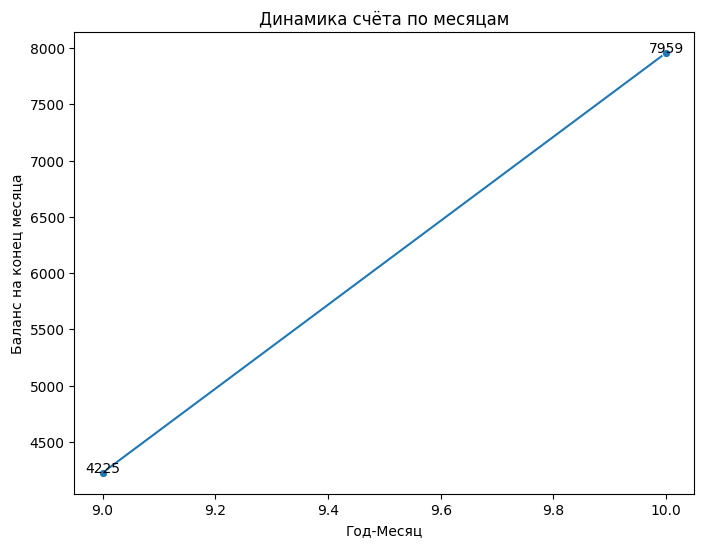


🧪 Тестирование счета ACC-100002...
Счёт ACC-100002 для Второй Клиент успешно создан. Баланс: 0.0 у.е.
-> Создан сберегательный счёт (SavingsAccount): ACC-100002 для Второй Клиент

Загрузка истории для ACC-100002 из C:\GitRepo\My-training-Slubik-Stanislav\transactions_dirty.csv...
Запущена очистка 27 транзакций...
Очистка завершена. Валидных транзакций: 18
Добавлено 18 новых транзакций в историю.
Баланс счёта ACC-100002 обновлён до: 5605.79 у.е. (на основе загруженных данных)
✅ Баланс: 5605.79. Загружено транзакций: 18

📝 Очищенная история для ACC-100002:


C:\Users\Happy\AppData\Local\Temp\ipykernel_20556\2897533784.py:222: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_corrected_groups = df.groupby(['account_number', 'account_type']).apply(self.fix_date)


,datetime,type,amount,balance_after
13,2025-10-14 22:17:26,withdraw,231.00,5482.53
14,2025-10-15 22:17:26,interest,274.13,5756.66
15,2025-10-17 22:17:26,withdraw,286.00,6342.66
16,2025-10-20 22:17:26,interest,302.13,6344.79
17,2025-10-23 22:17:26,withdraw,282.00,5605.79



📈 График истории ACC-100002:


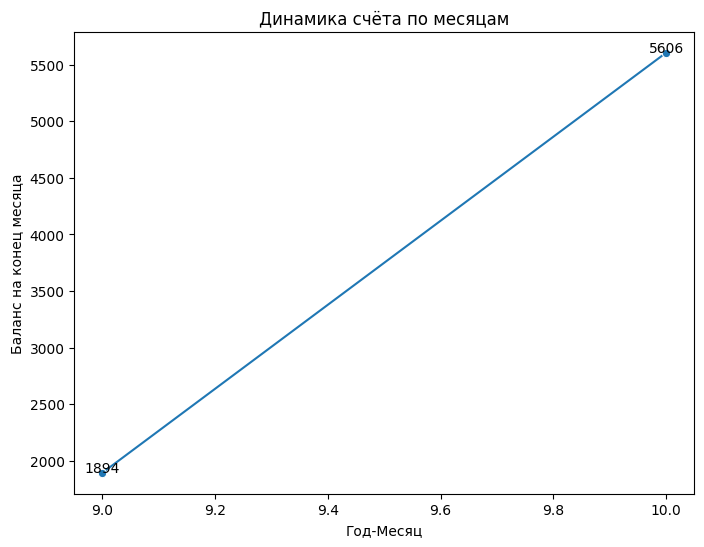


🧪 Тестирование счета ACC-100003...
Счёт ACC-100003 для Третий Клиент успешно создан. Баланс: 0.0 у.е.
-> Создан расчётный счёт (CheckingAccount): ACC-100003 для Третий Клиент

Загрузка истории для ACC-100003 из C:\GitRepo\My-training-Slubik-Stanislav\transactions_dirty.csv...
Запущена очистка 21 транзакций...
Очистка завершена. Валидных транзакций: 13
Добавлено 13 новых транзакций в историю.
Баланс счёта ACC-100003 обновлён до: 4634.0 у.е. (на основе загруженных данных)
✅ Баланс: 4634.00. Загружено транзакций: 13

📝 Очищенная история для ACC-100003:


C:\Users\Happy\AppData\Local\Temp\ipykernel_20556\2897533784.py:222: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_corrected_groups = df.groupby(['account_number', 'account_type']).apply(self.fix_date)


,datetime,type,amount,balance_after
8,2025-10-16 22:17:26,withdraw,187.0,4127.0
9,2025-10-17 22:17:26,deposit,999.0,5126.0
10,2025-10-18 22:17:26,withdraw,268.0,4858.0
11,2025-10-20 22:17:26,withdraw,118.0,4395.0
12,2025-10-21 22:17:26,deposit,239.0,4634.0



📈 График истории ACC-100003:


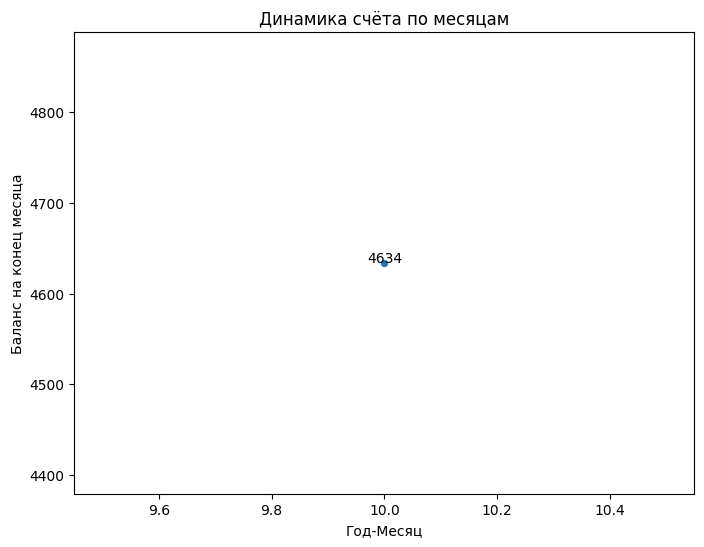


🧪 Тестирование счета ACC-100004...
Счёт ACC-100004 для Четвертый Клиент успешно создан. Баланс: 0.0 у.е.
-> Создан сберегательный счёт (SavingsAccount): ACC-100004 для Четвертый Клиент

Загрузка истории для ACC-100004 из C:\GitRepo\My-training-Slubik-Stanislav\transactions_dirty.csv...
Запущена очистка 31 транзакций...
Очистка завершена. Валидных транзакций: 19
Добавлено 19 новых транзакций в историю.
Баланс счёта ACC-100004 обновлён до: 10852.2 у.е. (на основе загруженных данных)
✅ Баланс: 10852.20. Загружено транзакций: 19

📝 Очищенная история для ACC-100004:


C:\Users\Happy\AppData\Local\Temp\ipykernel_20556\2897533784.py:222: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_corrected_groups = df.groupby(['account_number', 'account_type']).apply(self.fix_date)


,datetime,type,amount,balance_after
14,2025-10-15 22:17:26,deposit,789.00,8413.95
15,2025-10-17 22:17:26,deposit,864.00,9393.95
16,2025-10-19 22:17:26,deposit,671.00,10064.95
17,2025-10-19 22:17:26,interest,503.25,10568.20
18,2025-10-19 22:17:26,deposit,696.00,10852.20



📈 График истории ACC-100004:


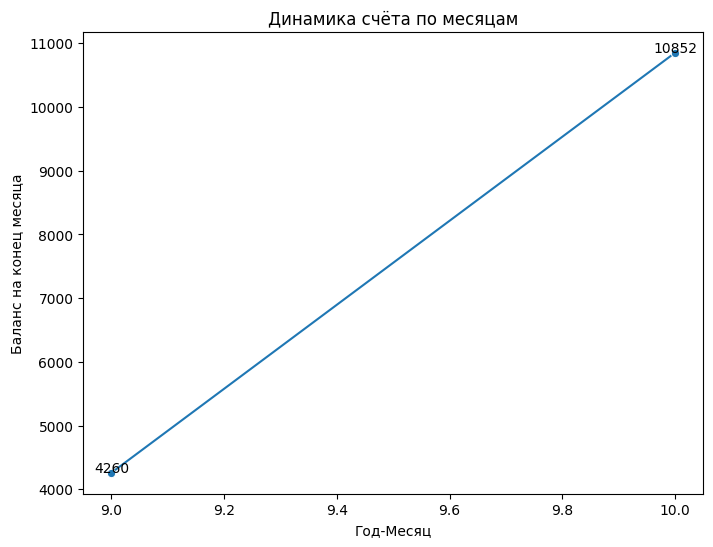

In [8]:
# -----------------------------------------------------------------
# ФИНАЛЬНЫЙ БЛОК ЗАПУСКА
# -----------------------------------------------------------------
print("--- 🔬 Запуск юнит-тестов (Проверка логики) 🔬 ---")

# Явный запуск юнит-тестов, который работает в Jupyter
loader = unittest.TestLoader()
suite = unittest.TestSuite()
suite.addTests(loader.loadTestsFromTestCase(TestAccount))
suite.addTests(loader.loadTestsFromTestCase(TestSavingsAccount))

runner = unittest.TextTestRunner(verbosity=2) 
# Запускаем юнит-тесты
runner.run(suite)

# Запускаем функциональный тест
run_multi_account_test(FILE_TO_TEST)